In [72]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial.distance import euclidean
import cv2 as cv

In [2]:
def order_contour(contour_init):
    contour_init = contour_init[:, [1, 0]] # cv 
    max_first_index = np.max(contour_init[:, 0])
    # Create a boolean mask to identify rows with the maximum first index
    filtered_data = contour_init[:, 0] == max_first_index
    min_second_index = np.min(contour_init[filtered_data, 1])
    # find index of max first index and min second index
    index = np.where((contour_init[:, 0] == max_first_index) & (contour_init[:, 1] == min_second_index))[0][0]
    rotated_arr = np.concatenate((contour_init[index:], contour_init[:index]))
    return rotated_arr

In [3]:
def calculate_starGT(instance_segmentation_map, n_rays = 32):
        """
        Calculate object prob for each pixel in the image.
        Args:
        - instance_segmentation_map: A 2D numpy array representing the instance segmentation map.
        - n_rays: The number of rays to sample for each instance.
        Returns:
        - object_probabilities: A 2D numpy array of the same shape as the input image with object probabilities.
        - star_distances: A 3D numpy array of shape (H, W, n_rays) with distances to the n_rays star points.
        - angles: A 3D numpy array of shape (H, W, n_rays) with angles to the n_rays star points.
        """

        # init the object probs with zeros
        object_probabilities = np.zeros_like(instance_segmentation_map, dtype=float)
        star_distances = np.zeros((instance_segmentation_map.shape[0],instance_segmentation_map.shape[1],n_rays), dtype=float)
        angles = np.zeros_like(star_distances, dtype=float)
        # iterate over each instance
        for inst in np.unique(instance_segmentation_map)[1:]:
            instance_pixels = (instance_segmentation_map == inst)
            contour_initial, _ = cv.findContours(instance_pixels.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            contour_initial = contour_initial[0][:, 0, :]
            contour = order_contour(contour_initial)
            # randomly sample n_rays points on the boundary
            contour_n = contour[np.linspace(0, len(contour) - 1, n_rays).astype(int)]

            # iterate over each pixel in the instance
            for i in range(instance_segmentation_map.shape[0]):
                for j in range(instance_segmentation_map.shape[1]):
                    if instance_pixels[i,j]:
                        distances_to_background = np.linalg.norm(
                        contour - np.array([i, j]), axis=1
                        )
                        min_distance = np.min(distances_to_background)
                        # normalize to [0, 1]
                        try:
                            object_probabilities[i, j] = min_distance / distances_to_background.max()
                        except:
                            object_probabilities[i, j] = 0
                        # calculate the distance from instace pixel to each ray point using np.linalg.norm
                        star_distances[i,j] = np.linalg.norm(contour_n - np.array([i, j]), axis=1)
                        # calc the angles with respect to the j-axis 
                        angles_ray = np.arctan2(contour_n[:, 1] - j, contour_n[:, 0] - i)
                        # angles from [-pi,pi] --> [0, 2pi] and normalize to [0, 1]
                        angles[i,j] = ((angles_ray + 2 * np.pi) % (2 * np.pi)) / (2 * np.pi)               
        return object_probabilities, star_distances, angles 

In [4]:
labels_path = "./data/labels.npy"
images_path = "./data/images.npy"

instance_map = np.load(labels_path)[5,:,:,0]
image = np.load(images_path)[5,:,:,:]

In [5]:
object_probabilities, star_distances, angles  = calculate_starGT(instance_map, n_rays = 16)


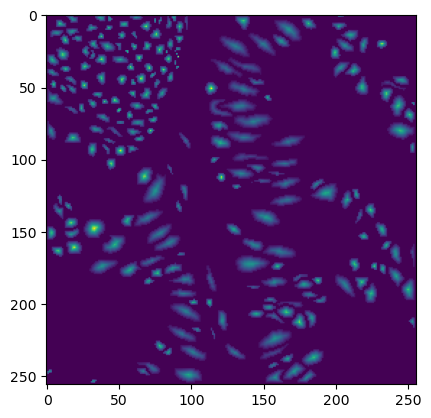

In [6]:
plt.imshow(object_probabilities)

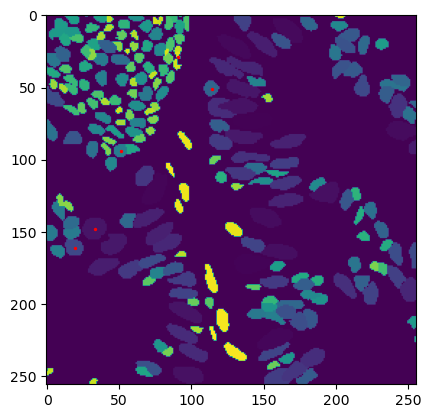

In [7]:
# select points where object_probabilities > 0.72
points = np.argwhere(object_probabilities > 0.68)
plt.imshow(instance_map)
plt.scatter(points[:,1], points[:,0], s=2, c='r')
plt.show()

In [8]:
import numpy as np

def calculate_endpoint(start_point, length, angle_rad):
    x_start, y_start = start_point
    delta_x = length * np.cos(angle_rad)
    delta_y = length * np.sin(angle_rad)
    x_end = x_start + delta_x
    y_end = y_start + delta_y
    return x_end, y_end

start_point = np.array([141,  56])
length = star_distances[start_point[0], start_point[1]]
angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
x , y = calculate_endpoint(start_point, length, angle_rad)
print(x,y)

[147. 147. 147. 147. 145. 143. 141. 139. 138. 138. 138. 138. 140. 142.
 144. 146.] [54. 55. 57. 59. 59. 59. 60. 61. 60. 58. 56. 54. 53. 51. 51. 53.]


[ 2 37]
[0.         0.32175055 0.5880026  1.10714872 1.32581766 1.81577499
 2.03444394 2.15879893 2.67794504 3.14159265 3.92699082 4.12438638
 4.24874137 4.71238898 5.03413953 5.8195377 ]
[ 2 88]
[0.         0.         0.32175055 0.78539816 1.10714872 1.57079633
 2.03444394 2.35619449 2.67794504 3.14159265 3.60524026 3.92699082
 4.24874137 4.71238898 5.49778714 5.8195377 ]
[ 4 75]
[5.8195377  5.8195377  0.         0.46364761 0.46364761 0.78539816
 1.57079633 1.57079633 2.35619449 3.14159265 3.14159265 3.60524026
 3.92699082 3.92699082 4.71238898 5.49778714]
[  6 181]
[0.38050638 0.64350111 0.89605538 1.24904577 1.57079633 2.03444394
 2.55359005 3.14159265 3.38657132 3.78509376 4.03764804 4.3318826
 4.71238898 5.30039158 6.03820664 0.24497866]
[ 8 92]
[6.08578975 0.         0.19739556 0.5880026  0.78539816 1.57079633
 1.89254688 2.15879893 2.89661399 3.14159265 3.72959526 3.92699082
 4.39063843 5.03413953 5.49778714 5.8195377 ]
[  8 202]
[5.96143475 0.         0.78539816 0.98279372 1.37

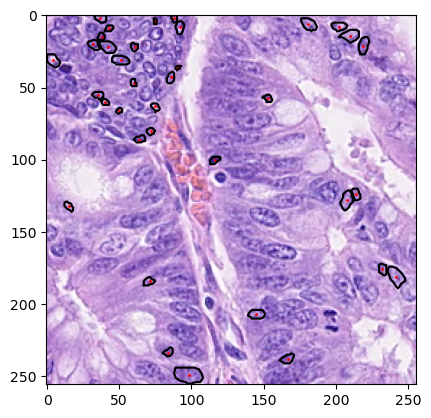

In [9]:
# calculate 99.5 percentile object_probabilities
percentile_99_5 = np.percentile(object_probabilities, 99.5)
# select points whcih are atleast 5 pixels away from each other
def filter_points(points, x):
    filtered_points = []
    
    for i, point1 in enumerate(points):
        is_valid = True
        
        for j, point2 in enumerate(points):
            if i != j:  # Avoid comparing the point to itself
                distance = np.linalg.norm(np.array(point1) - np.array(point2))
                if distance < x:
                    is_valid = False
                    break  # No need to check other points
                
        if is_valid:
            filtered_points.append(point1)
    
    return np.array(filtered_points)

# select points where object_probabilities > percentile_99.5
mid_points = np.argwhere(object_probabilities > percentile_99_5)
# filter points
filtered_points = filter_points(mid_points, 5)
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
for point in filtered_points:
    start_point = point
    length = star_distances[start_point[0], start_point[1]]
    angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
    print(point)
    print(angle_rad)
    x , y = calculate_endpoint(start_point, length, angle_rad)
    plt.plot(y,x, c='black')
plt.show()

In [10]:
star_d = (star_distances[filtered_points[:,0],filtered_points[:,1]])
star_theta = (angles[filtered_points[:,0],filtered_points[:,1]] * 2 * np.pi)
delta_x = star_d * np.cos(star_theta)
delta_y = star_d * np.sin(star_theta)
x_end = filtered_points[:,0].reshape(-1,1) + delta_x
y_end = filtered_points[:,1].reshape(-1,1) + delta_y

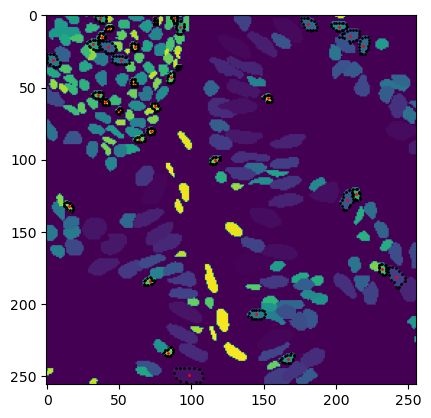

In [11]:
plt.imshow(instance_map)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')

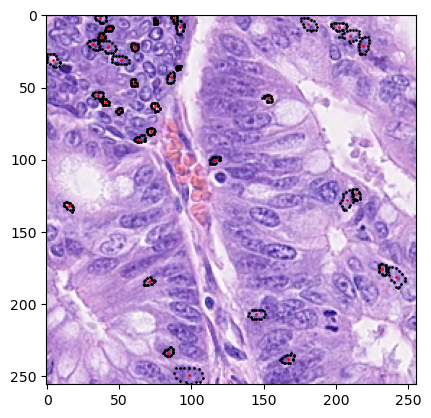

In [12]:
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')

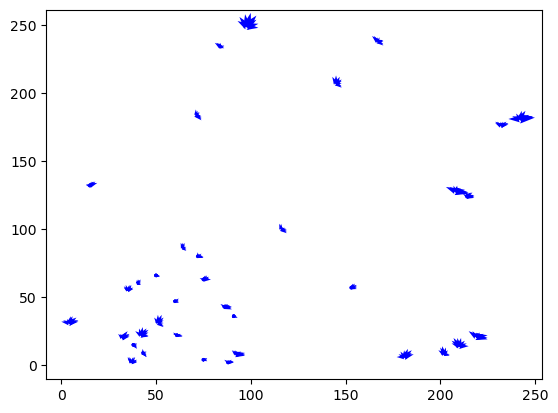

In [13]:
fig, ax = plt.subplots()

for i in range(len(filtered_points)):
    for j in range(8):
        ax.quiver(filtered_points[i,1], filtered_points[i,0], delta_x[i,j], delta_y[i,j], angles='xy', scale_units='xy', scale=1, color='b')

## check circular loss

In [16]:
import torch

In [20]:
from utils.circular_loss import CircularAELoss
criterion = CircularAELoss()
a = torch.tensor([[0.2,0.4,0.6],[0.8,1.0,0.6]])
b = torch.tensor([[1,0,1],[0,1,0]])
loss = criterion(a,b)

In [21]:
loss

tensor([[0.2000, 0.4000, 0.4000],
        [0.2000, 0.0000, 0.4000]])

## Create a toy data set to test 

In [73]:
images_path = "./data/images.npy"
labels_path = "./data/labels.npy"

images = np.load(images_path)
labels = np.load(labels_path)

toy_images = images[:2400,:,:,:]
toy_labels = labels[:2400,:,:,:]

save_images_path = "./data/images_50.npy"
save_labels_path = "./data/labels_50.npy"

np.save(save_images_path, toy_images)
np.save(save_labels_path, toy_labels)